# CO2 Emissions Classification Model

## Objective
Develop an ML model to predict whether CO2 emissions from specific sources will increase or decrease based on historical data. The target variable is categorical, representing the two classes: increase (1) or decrease (0). This model will be a supervised, binary classification model.

## Success Metrics
- Achieve at least 80% recall for predicting increases in emissions on both the training and test sets.
- The model will be considered a failure if:
  - After three months of deployment, more than 30% of predicted increases in emissions are incorrect.
  - The precision for predicting decreases in emissions is lower than 80% on both the training and test sets.

## Model Output
A flag indicating whether CO2 emissions will increase or decrease, along with the associated probability. Predictions will be made in real-time, based on input data provided by environmental analysts.

## Training Data
Historical data on CO2 emissions, excluding non-predictive variables like unique identifiers.

## Inputs
- outputs/datasets/collection/Co2Emissions.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs
- Train set (features and target)
- Test set (features and target)
- ML pipeline to predict Co2 Increase or Decrease
- labels map
- Feature Importance Plot


# Change working directory

We need to change the working directory from its current folder to its parent folder
-    We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle\\jupyter_notebooks'

I want to make the parent of the current directory the new current directory.
- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle'

## Load Data
- Load the dataset and display basic information.

In [4]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('C:outputs\datasets\collection\Co2Emissions.csv')

# Display basic information
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     63104 non-null  object 
 1   Year        63104 non-null  int64  
 2   Total       62904 non-null  float64
 3   Coal        21744 non-null  float64
 4   Oil         21717 non-null  float64
 5   Gas         21618 non-null  float64
 6   Cement      20814 non-null  float64
 7   Flaring     21550 non-null  float64
 8   Other       1620 non-null   float64
 9   Per Capita  18974 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 4.8+ MB
None
               Year         Total          Coal           Oil           Gas  \
count  63104.000000  62904.000000  21744.000000  21717.000000  21618.000000   
mean    1885.500000     55.224788     73.968916     55.760624     23.504285   
std       78.519728    824.845435    598.986992    519.034563    247.674772   
min     1750.000

In [11]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

## Check for missing values and define the target variable and features.

- Calculate the year-over-year change in CO2 emissions.
- Create a binary target variable: Use the change in emissions to create a binary target variable where 1 indicates an increase and 0 indicates a decrease.

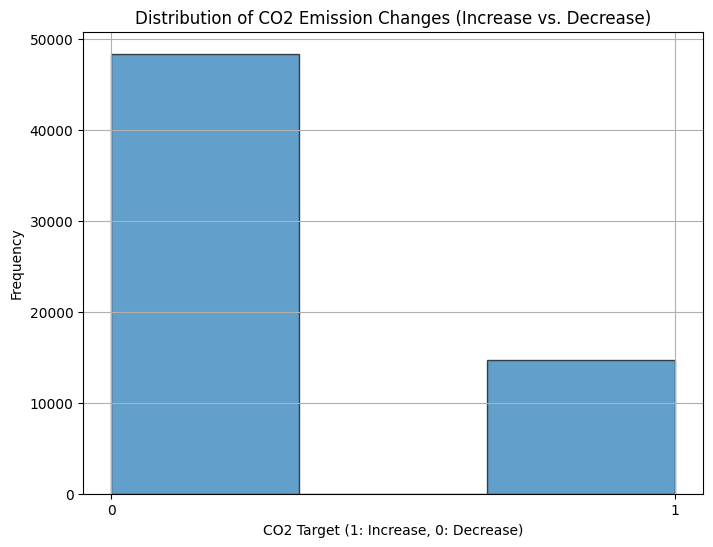

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Check for missing values
df.isnull().sum()

# Calculate the year-over-year change in CO2 emissions
df['CO2_Change'] = df.groupby('Country')['Total'].pct_change()

# Create the target variable: 1 for increase, 0 for decrease
df['CO2_Target'] = (df['CO2_Change'] > 0).astype(int)

# Drop rows with NaN values in the target variable
df = df.dropna(subset=['CO2_Target'])

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for remaining NaN values and impute them if necessary
df.fillna(method='ffill', inplace=True)  # Forward fill to handle NaNs

# Define the target variable and features
X = df.drop(['CO2_Target', 'CO2_Change', 'Country'], axis=1)
y = df['CO2_Target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
plt.hist(y, bins=3, edgecolor='k', alpha=0.7)
plt.title('Distribution of CO2 Emission Changes (Increase vs. Decrease)')
plt.xlabel('CO2 Target (1: Increase, 0: Decrease)')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.grid(True)
plt.show()



## MP Pipeline: Regressor
- Create ML pipeline

In [43]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [44]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [45]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = df.drop(['CO2_Target'], axis=1)  # Drop unnecessary columns
y = df['CO2_Target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (50483, 11) (50483,) 
* Test set: (12621, 11) (12621,)


## Grid Search CV - Sklearn
- Use default hyperparameters to find most suitable algorithm

In [58]:
models_quick_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [59]:
# Inspect the dataframe to check column names and types
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     63104 non-null  object 
 1   Year        63104 non-null  int64  
 2   Total       63104 non-null  float64
 3   Coal        62905 non-null  float64
 4   Oil         62905 non-null  float64
 5   Gas         62905 non-null  float64
 6   Cement      62905 non-null  float64
 7   Flaring     62905 non-null  float64
 8   Other       59872 non-null  float64
 9   Per Capita  62904 non-null  float64
 10  CO2_Change  62904 non-null  float64
 11  CO2_Target  63104 non-null  int32  
dtypes: float64(9), int32(1), int64(1), object(1)
memory usage: 5.5+ MB
None
       Country  Year  Total  Coal  Oil  Gas  Cement  Flaring  Other  \
0  Afghanistan  1750    0.0   NaN  NaN  NaN     NaN      NaN    NaN   
1  Afghanistan  1751    0.0   NaN  NaN  NaN     NaN      NaN    NaN   
2  Afghanistan  1752    0.0

In [60]:
# Create an instance of HyperparameterOptimizationSearch
search = HyperparameterOptimizationSearch(models_quick_search, params_quick_search)

# Fit the search object to the training data
search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2')



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [61]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,RandomForestRegressor,0.996069,0.997228,0.998195,0.000692
0,DecisionTreeRegressor,0.995592,0.996527,0.997726,0.000774
2,XGBRegressor,0.981331,0.984104,0.986356,0.001605


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.
- Define model and parameters, for Extensive Search

In [62]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
    }
}

Extensive GridSearch CV

In [63]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [64]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
2,RandomForestRegressor,0.996069,0.997271,0.998318,0.000728,10,100
3,RandomForestRegressor,0.996025,0.99725,0.998273,0.000726,10,300
4,RandomForestRegressor,0.996069,0.997228,0.998195,0.000692,None,100
5,RandomForestRegressor,0.996031,0.997209,0.998148,0.000688,None,300
1,RandomForestRegressor,0.995572,0.996512,0.997695,0.00069,3,300
0,RandomForestRegressor,0.995606,0.996471,0.997492,0.000617,3,100


Check the best model

In [65]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Parameters for best model

In [66]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 10, 'model__n_estimators': 100}

Define the best regressor, based on search

In [67]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model', RandomForestRegressor(max_depth=10, random_state=0))])

Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['Total', 'CO2_Change']


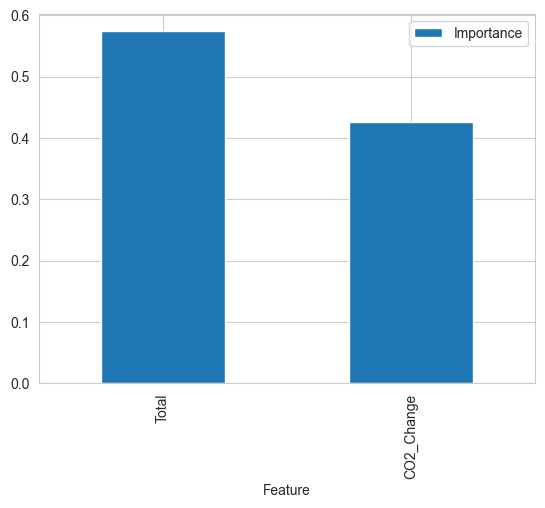

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Evaluate on Train and Test Sets

In [82]:
%matplotlib inline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

In [83]:
def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")
